In [1]:
DATA_DIR_BASE = "/scratch/cmpe258-sp25/group3_styletransfer/"
COCO_UNLABLED = DATA_DIR_BASE + "unlabeled2017/unlabeled2017/"
ART_STYLE = DATA_DIR_BASE + "wikiart/"

In [2]:
from torchvision.models import vgg19, VGG19_Weights
import torch
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
print(f"default device: {torch.get_default_device()}")

default device: cuda:0


In [3]:
vgg = vgg19(weights=VGG19_Weights.DEFAULT)
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [4]:
import losses as loss
import data_feat_load as dfl

In [5]:
vgg = vgg19(weights='VGG19_Weights.IMAGENET1K_V1').features.to(device).eval()
# Extract intermediate layers for content & style
content_layers = ['conv4_2']
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

def get_features(image, model):
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2',
        '28': 'conv5_1'
    }
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

In [6]:
def style_transfer(content, style, model, content_weight=1, style_weight=1e6, steps=5000, stop_threshold=10000):

    target = content.clone().requires_grad_(True).to(device) # Target Image
    optimizer = torch.optim.Adam([target], lr=0.005)

    for i in range(steps):
        target_features = get_features(target, model)
        content_features = get_features(content, model)
        style_features = get_features(style, model)

        # Content loss (MSE)
        content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

        # Style loss
        style_loss = 0
        for layer in ['conv1_1','conv2_1','conv3_1','conv4_1','conv5_1']:
            target_f = target_features[layer]
            style_f = style_features[layer]
            _, c, h, w = target_f.shape
            target_gram = torch.mm(target_f.view(c, h * w), target_f.view(c, h * w).t())
            style_gram = torch.mm(style_f.view(c, h * w), style_f.view(c, h * w).t())
            layer_style_loss = torch.mean((target_gram - style_gram)**2) / (c * h * w)
            style_loss += layer_style_loss

        total_loss = content_weight * content_loss + style_weight * style_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        with torch.no_grad():
            target.clamp_(0, 1)

        if i % 100 == 0:
            print(f"Step [{i}/{steps}]  Total Loss: {total_loss.item():.2f}")

        if total_loss.item() < stop_threshold:
            print(f"Stopping early at step {i}, total loss = {total_loss.item():.2f}")
            break

    return target


In [7]:
def style_transfer(content, style, model, 
                   style_layers=['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1'],
                   content_layers = ['conv4_2'], 
                   content_weight=1, style_weight=1e6, steps=5000, stop_threshold=10000,
                   loss_method="gram"):

    target = content.clone().requires_grad_(True).to(device) # Target Image
    optimizer = torch.optim.Adam([target], lr=0.005)

    for i in range(steps):
        target_features = get_features(target, model)
        content_features = get_features(content, model)
        style_features = get_features(style, model)

        # Content loss (MSE)
        content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

        # Style loss
        style_loss = 0
        for layer in style_layers:
            target_f = target_features[layer]
            style_f = style_features[layer]
            _, c, h, w = target_f.shape
            if loss_method.lower() == "gram":
                target_gram = torch.mm(target_f.view(c, h * w), target_f.view(c, h * w).t())
                style_gram = torch.mm(style_f.view(c, h * w), style_f.view(c, h * w).t())
                layer_style_loss = torch.mean((target_gram - style_gram)**2) / (c * h * w)
            elif loss_method.lower() =="adain":
                target_adain = loss.adaptive_instance_normalization()
                style_adain = loss.adaptive_instance_normalization()
                layer_style_loss = "TODO"
            style_loss += layer_style_loss

        total_loss = content_weight * content_loss + style_weight * style_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        with torch.no_grad():
            target.clamp_(0, 1)

        if i % 100 == 0:
            print(f"Step [{i}/{steps}]  Total Loss: {total_loss.item():.2f}")

        if total_loss.item() < stop_threshold:
            print(f"Stopping early at step {i}, total loss = {total_loss.item():.2f}")
            break

    return target


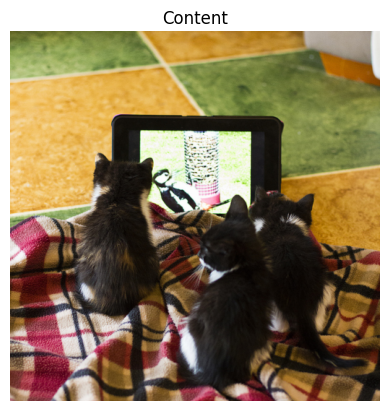

In [8]:
content_img = f"{COCO_UNLABLED}/000000160675.jpg"
content = dfl.load_image(content_img,dfl.get_transforms(dfl.IMG_SIZE),device)
dfl.imshow(content, "Content")


Style image: /scratch/cmpe258-sp25/group3_styletransfer/wikiart//Ukiyo_e/katsushika-hokusai_wooden-horse.jpg


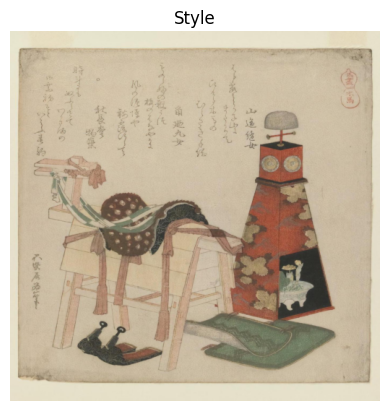

In [26]:
style_img= f"{ART_STYLE}/Ukiyo_e/katsushika-hokusai_wooden-horse.jpg"
# style_img = random.choice(wikiart_images)
style = dfl.load_image(style_img,dfl.get_transforms(dfl.IMG_SIZE),device)
dfl.imshow(style, "Style")
print("Style image:", style_img)

In [28]:
start = time.time()
output = style_transfer(content, style, vgg, steps=5000, stop_threshold=10000)
end = time.time()
print(f"time taken: {end-start:.03f}s")

Step [0/5000]  Total Loss: 8933749.00
Step [100/5000]  Total Loss: 321917.97
Step [200/5000]  Total Loss: 208786.14
Step [300/5000]  Total Loss: 172624.48
Step [400/5000]  Total Loss: 152059.83
Step [500/5000]  Total Loss: 141483.12
Step [600/5000]  Total Loss: 124201.36
Step [700/5000]  Total Loss: 126017.17
Step [800/5000]  Total Loss: 105927.79
Step [900/5000]  Total Loss: 98970.91
Step [1000/5000]  Total Loss: 96038.45
Step [1100/5000]  Total Loss: 86999.11
Step [1200/5000]  Total Loss: 85160.67
Step [1300/5000]  Total Loss: 76924.83
Step [1400/5000]  Total Loss: 79423.06
Step [1500/5000]  Total Loss: 70116.88
Step [1600/5000]  Total Loss: 68780.48
Step [1700/5000]  Total Loss: 62573.02
Step [1800/5000]  Total Loss: 64963.29
Step [1900/5000]  Total Loss: 59557.88
Step [2000/5000]  Total Loss: 77447.49
Step [2100/5000]  Total Loss: 54357.75
Step [2200/5000]  Total Loss: 51866.50
Step [2300/5000]  Total Loss: 48712.93
Step [2400/5000]  Total Loss: 50756.70
Step [2500/5000]  Total Los

NameError: name 'imshow' is not defined

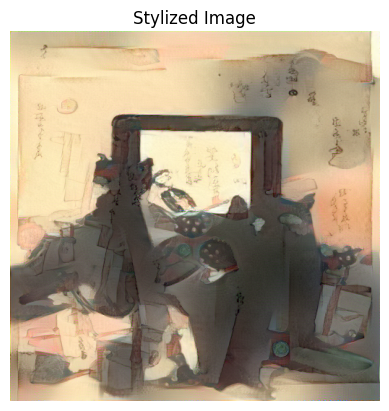

In [29]:
dfl.imshow(output, "Stylized Image")

In [ ]:

style_img= f"{ART_STYLE}/Ukiyo_e/katsushika-hokusai_wooden-horse.jpg"
# style_img = random.choice(wikiart_images)
style = dfl.load_image(style_img,dfl.get_transforms(dfl.IMG_SIZE),device)
dfl.imshow(style, "Style")
print("Style image:", style_img)

start = time.time()
output = style_transfer(content, style, vgg, steps=5000, stop_threshold=10000)
end = time.time()
print(f"time taken: {end-start:.03f}s")
imshow(output, "Stylized Image")

In [ ]:
!ls /scratch/cmpe258-sp25/group3_styletransfer/wikiart/

## Dataset Exploration

In [39]:
import glob
import cv2
threads = int(cpu_count()/16) # 16 on g17 hpc
files = glob.glob(COCO_UNLABLED + "*")
sizes = []
from multiprocessing import Pool, cpu_count

In [45]:
def get_size_cv(path):
    img = cv2.imread(path)
    if img is not None:
        h, w = img.shape[:2]
        return (w, h)
    return None

In [46]:
sizes_wiki = []
art_files = glob.glob(ART_STYLE+"**/*")
with Pool(threads) as p:
    sizes_wiki = p.map(get_size_cv, art_files)

In [ ]:
with Pool(threads) as p:
    sizes = p.map(get_size_cv, files)

In [62]:
import numpy as np
sz_arr = np.array(sizes)
art_sz_arr = np.array(sizes_wiki)

In [63]:
np.median(sz_arr[:,0]),np.median(sz_arr[:,1]),np.median(art_sz_arr[:,0]),np.median(art_sz_arr[:,1]),

(640.0, 480.0, 1382.0, 1492.0)

In [64]:
np.min(sz_arr[:,0]),np.min(sz_arr[:,1]),np.min(art_sz_arr[:,0]),np.min(art_sz_arr[:,1]),

(75, 67, 1381, 1381)

In [65]:
np.max(sz_arr[:,0]),np.max(sz_arr[:,1]),np.max(art_sz_arr[:,0]),np.max(art_sz_arr[:,1]),

(640, 640, 15754, 17768)

In [74]:
128*2

256